In [1]:
import pyfits
import math as m
import numpy as np
from numpy import linalg
from numpy import random
import scipy as sp
from scipy import stats
from scipy.stats import norm
import sys
import emcee
import cProfile
import pstats
import StringIO
import sympy as sy
import cPickle
import os
import random
import bisect
import collections
import hickle as hkl

%matplotlib inline
import matplotlib.pyplot as plt
colors='bgrcmyk'
plt.rc('axes',color_cycle=['b','g','r','c','m','y'])
plt.rc('text', usetex=True)

In [2]:
#set up for probability distributions
#all p(z) share these bins from Sheldon, et al.
zbins = pyfits.open(os.path.join('../big-data/','zbins-12.fits'))

#reformat bins
zlos = [zbins[1].data[i][0] for i in range(0,len(zbins[1].data))]
zhis = [zbins[1].data[i][1] for i in range(0,len(zbins[1].data))]
nbins = len(zbins[1].data)

#use centers of bins for plotting
zmids = [(zbins[1].data[i][0]+zbins[1].data[i][1])/2. for i in range(0,nbins)]
zavg = sum(zmids)/nbins

#useful for plotting
zdifs = [zbins[1].data[i][1]-zbins[1].data[i][0] for i in range(0,nbins)]
zdif = sum(zdifs)/nbins

In [308]:
#generate number of galaxies to draw
nsamps = 1#instantiations of the survey
seed_ngals = 2*np.arange(1,6)#[1,10]#can generate for different survey sizes
nsurvs = len(seed_ngals)
ngals = [nsamps*[seed_ngals[s]] for s in range(0,nsurvs)]
#for poisson sampling instead of set survey size -- small number tests fail when sample size is 0!
# ngals = [[np.random.poisson(seed_ngals[i]) for i in range(0,nsurvs)] for n in range(0,nsamps)]

In [310]:
#set true value of N(z)=theta
#tuples of form z_center, spread,magnitude
realistic_prep = [(0.2,0.005,2.0),(0.4,0.005,1.25),(0.5,0.1,2.0),(0.6,0.005,1.25),(0.8,0.005,1.25),(1.0,0.005,0.75)]
realistic_comps = np.transpose([[zmid*tup[2]*(2*m.pi*tup[1])**-0.5*m.exp(-(zmid-tup[0])**2/(2*tup[1])) for zmid in zmids] for tup in realistic_prep])
realistic = [sum(realistic_comps[k]) for k in range(0,nbins)]
realsum = sum(realistic)
realistic_pdf = np.array([realistic[k]/realsum/zdifs[k] for k in range(0,nbins)])

In [311]:
plotrealistic = [sum(real) for real in realistic_comps]
plotrealisticsum = sum(plotrealistic)
plotrealistic_comps = np.transpose([[r/plotrealisticsum for r in real] for real in realistic_comps])
plotrealistic_pdf = np.array([plotrealistic[k]/plotrealisticsum for k in range(0,nbins)])

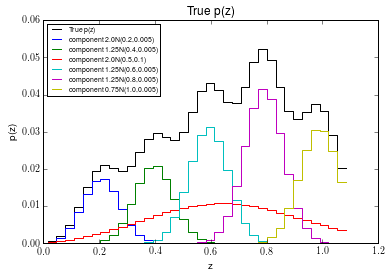

In [312]:
#plot the true p(z) and its components
plt.figure(1)
plt.title('True p(z)')# for $J=$'+str(ngals_seed))
plt.step(zmids,plotrealistic_pdf,c='k',label='True p(z)')
for k in range(0,len(plotrealistic_comps)):
    plt.step(zmids,plotrealistic_comps[k],c=colors[k],label='component '+str(realistic_prep[k][2])+'N('+str(realistic_prep[k][0])+','+str(realistic_prep[k][1])+')')
plt.ylabel('p(z)')
plt.xlabel('z')
plt.legend(fontsize='x-small',loc='upper left')
#plt.savefig('truePz.png')
plt.show()
plt.close()

In [313]:
trueNz = [seed_ngals[s]*realistic_pdf for s in range(0,nsurvs)]
truePz = [realistic_pdf for s in range(0,nsurvs)]
logtrueNz = [[m.log(max(trueNz[s][k],sys.float_info.epsilon)) for k in range(0,nbins)] for s in range(0,nsurvs)]
logtruePz = [[m.log(max(truePz[s][k],sys.float_info.epsilon)) for k in range(0,nbins)] for s in range(0,nsurvs)]

In [218]:
##set up for random selection of galaxies per bin
#def cdf(weights):
#    tot = sum(weights)
#    result = []
#    cumsum = 0
#    for w in weights:
#        cumsum += w
#        result.append(cumsum / tot)
#    return result
#def choice(pop, weights):
#    assert len(pop) == len(weights)
#    cdf_vals = cdf(weights)
#    x = random.random()
#    index = bisect.bisect(cdf_vals, x)
#    return pop[index]

In [13]:
##randomly select bin counts from true N(z)
#bincounts = []
#for s in range(0,nsurvs):
#    bincount = []
#    for n in range(0,nsamps):
#        count = [0]*nbins
#        for i in range(0,ngals[s][n]):
#            count[choice(range(0,nbins), trueNz[s])] += 1
#            bincount.append(count)
#    bincounts.append(bincount)
#
#plotcounts = [[[max(bincounts[s][n][k]/zdifs[k],sys.float_info.epsilon) for k in range(0,nbins)] for n in range(0,nsamps)] for s in range(0,nsurvs)]
#logplotcounts = np.log(np.array(plotcounts))

In [314]:
#test case: all galaxies in survey have same true redshift
chosenbin = np.argmax(plotrealistic_pdf)#random.sample(range(0,35),1)
chosenbins = chosenbin*nsurvs
bincounts = []
for s in range(0,nsurvs):
    bincount = []
    for n in range(0,nsamps):
        count = [0]*nbins
        count[chosenbin] = ngals[s][n]
        bincount.append(np.array(count))
    bincounts.append(np.array(bincount))
bincounts = np.array(bincounts)

#plotcounts = [[[max(bincounts[s][n][k]/zdifs[k],sys.float_info.epsilon) for k in range(0,nbins)] for n in range(0,nsamps)] for s in range(0,nsurvs)]
#logplotcounts = np.log(np.array(plotcounts))

sampPz = np.array([[bincounts[s][n]/ngals[s][n]/zdif for n in range(0,nsamps)] for s in range(0,nsurvs)])
logsampPz = np.log(np.array([[[max(o,sys.float_info.epsilon) for o in counts] for counts in samp] for samp in obsPz]))

sampNz = np.array([[bincounts[s][n]/zdif for n in range(0,nsamps)] for s in range(0,nsurvs)])
logsampNz = np.log(np.array([[[max(o,sys.float_info.epsilon) for o in counts] for counts in samp] for samp in sampNz]))

In [315]:
#define flat distribution for N(z)
avgprob = 1./nbins/zdif
logavgprob = m.log(avgprob)
flat = [seed*avgprob for seed in seed_ngals]
logflat = [m.log(f) for f in flat]
flatNz = [np.array([f]*nbins) for f in flat]
logflatNz = [np.array([lf]*nbins) for lf in logflat]
flatPz = [np.array([avgprob]*nbins) for s in range(0,nsurvs)]
logflatPz = np.log(flatPz)#[np.array([avg_prob]*nbins) for s in range(0,nsurvs)]

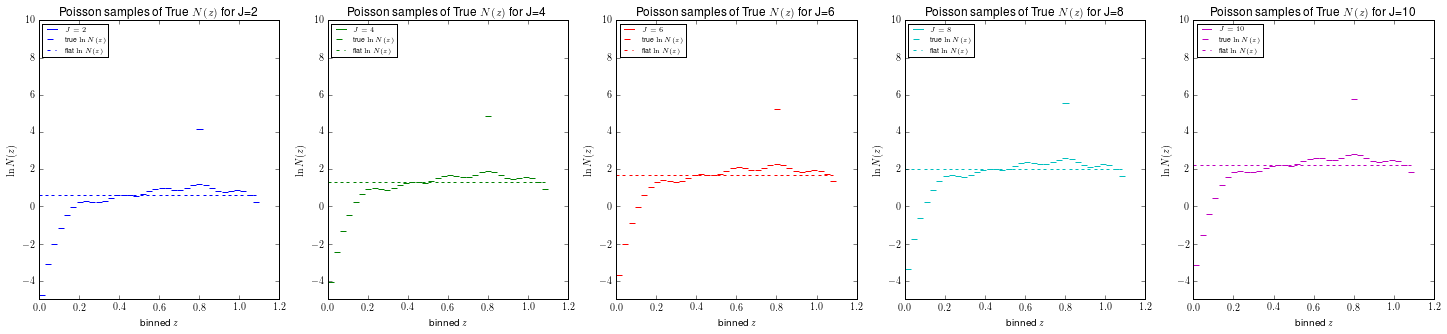

In [322]:
#plot samples of true N(z)
f, sps = plt.subplots(1, nsurvs, figsize=(5*nsurvs,5))
for s in range(0,nsurvs):
    sps[s].set_title(r'Poisson samples of True $N(z)$ for J='+str(seed_ngals[s]))
    sps[s].set_xlabel(r'binned $z$')
    sps[s].set_ylabel(r'$\ln N(z)$')
    sps[s].hlines(logtrueNz[s],zlos,zhis,color=colors[s],linestyle='--',label=r'true $\ln N(z)$')
    sps[s].hlines(logflatNz[s],zlos,zhis,color=colors[s],linestyle='-.',label=r'flat $\ln N(z)$')
    sps[s].step(zmids,[-10]*nbins,color=colors[s],label=r'$J='+str(seed_ngals[s])+r'$')
    for n in range(0,nsamps):
        sps[s].hlines(logsampNz[s][n],zlos,zhis,color=colors[s%6])#,alpha=0.1)
    sps[s].set_ylim(-5,10)
#plt.savefig('obsPz.png')
    sps[s].legend(loc='upper left',fontsize='x-small')
f.show()

In [323]:
#turn bin numbers into redshifts for histogram later
idealZs = np.array([[[zmids[k] for k in range(0,nbins)] for j in range(0,int(round(trueNz[s][k])))] for s in range(0,nsurvs)])

#assign actual redshifts uniformly within each bin
# trueZs = np.array([[[random.uniform(zlos[k],zhis[k]) for k in range(0,nbins) for j in range(0,bincounts[s][n][k])] for n in range(0,nsamps)] for s in range(0,nsurvs)])

#test case: all galaxies have same true redshift
trueZs = np.array([[[zmids[k] for k in range(0,nbins) for j in range(0,bincounts[s][n][k])] for n in range(0,nsamps)] for s in range(0,nsurvs)])

#jitter zs to simulate inaccuracy
# sigZs = np.array([[[zdif*(trueZs[s][n][j]+1.) for j in range(0,ngals[s][n])] for n in range(0,nsamps)] for s in range(0,nsurvs)])#zdif*(trueZs+1.)
# shiftZs = np.array([[[random.gauss(trueZs[s][n][j],sigZs[s][n][j]) for j in range(0,ngals[s][n])] for n in range(0,nsamps)] for s in range(0,nsurvs)])

#test case: perfect observations
shiftZs = trueZs
sigZs = np.array([[[zdif*(trueZs[s][n][j]+1.) for j in range(0,ngals[s][n])] for n in range(0,nsamps)] for s in range(0,nsurvs)])

In [324]:
#write out the data into a "catalog"

for s in range(0,nsurvs):
    for n in range(0,nsamps):
        catfile = open(str(n+1)+'datacat'+str(seed_ngals[s])+'.p','w')
        catdat = zip(shiftZs[s],sigZs[s])
        cPickle.dump(catdat,catfile)
        catfile.close()
#    truefile = open(str(nsamps)+'truecat'+str(seed_ngals[s])+'.p','w')
#    cattrue = trueZs[s]
#    cPickle.dump(cattrue,truefile)
#    truefile.close()

In [325]:
#define additional bins for points thrown out of Sheldon range by shifting
minshift = min([min([min(shift) for shift in shiftZ]) for shiftZ in shiftZs])
maxshift = max([max([max(shift) for shift in shiftZ]) for shiftZ in shiftZs])

binfront = [min(zlos)+x*zdif for x in range(int(m.floor((minshift-min(zlos))/zdif)),0)]
binback = [max(zhis)+x*zdif for x in range(1,int(m.ceil((maxshift-max(zhis))/zdif)))]
binends = np.array(binfront+sorted(set(zlos+zhis))+binback)
binlos = binends[:-1]
binhis = binends[1:]
new_nbins = len(binends)-1
binmids = [(binends[k]+binends[k+1])/2. for k in range(0,new_nbins)]

#define true N(z),P(z) for plotting given number of galaxies
full_trueNz = [np.append(np.array([sys.float_info.epsilon]*len(binfront)),(np.append(trueNz[s],np.array([sys.float_info.epsilon]*len(binback))))) for s in range(0,nsurvs)]
full_logtrueNz = [[m.log(full_trueNz[s][k]) for k in range(0,new_nbins)] for s in range(0,nsurvs)]
full_truePz = [np.append(np.array([sys.float_info.epsilon]*len(binfront)),(np.append(truePz[s],np.array([sys.float_info.epsilon]*len(binback))))) for s in range(0,nsurvs)]
full_logtruePz = [[m.log(full_truePz[s][k]) for k in range(0,new_nbins)] for s in range(0,nsurvs)]

#define flat N(z),P(z)
full_flatNz = [np.array([f]*new_nbins) for f in flat]
full_logflatNz = [np.array([lf]*new_nbins) for lf in logflat]
full_flatPz = [np.array([avgprob]*new_nbins) for s in range(0,nsurvs)]
full_logflatPz = [np.array([logavgprob]*new_nbins) for s in range(0,nsurvs)]

In [326]:
#bin the true and observed samples
sampNz = []
obsNz = []
for s in range(0,nsurvs):
    samp = []
    obs = []
    for n in range(0,nsamps):
        samphist = [sys.float_info.epsilon]*len(binmids)
        obshist = [sys.float_info.epsilon]*len(binmids)
        for j in range(0,ngals[s][n]):
            for k in range(0,new_nbins):
                if binends[k]<=trueZs[s][n][j] and trueZs[s][n][j]<binends[k+1]:
                    samphist[k]+=1./zdif
                if binends[k]<=shiftZs[s][n][j] and shiftZs[s][n][j]<binends[k+1]:
                    obshist[k]+=1./zdif    
        samp.append(samphist)
        obs.append(obshist)
    sampNz.append(samp)
    obsNz.append(obs)
sampNz = np.array(sampNz)
obsNz = np.array(obsNz)
obsPz = np.array([[obsNz[s][n]/ngals[s][n] for n in range(0,nsamps)] for s in range(0,nsurvs)])
    
logsampNz = np.log(sampNz)#)[[[m.log(trueNz[s][n][k]) for k in range(0,new_nbins)] for n in range(0,ndraws)]
logobsNz = np.log(obsNz)#[[m.log(shiftNz[s][n][k]) for k in range(0,new_nbins)] for n in range(0,ndraws)]
logobsPz = np.log(obsPz)

In [327]:
#calculate mean and rms errors (over many draws) on bin heights

avgsamp,avgobs,rmssamp,rmsobs = [],[],[],[]

for s in range(0,nsurvs):
    samp = np.transpose(sampNz[s])
    obs = np.transpose(obsNz[s])
    avgsamp.append([np.mean(z) for z in samp])
    avgobs.append([np.mean(z) for z in obs])
    rmssamp.append([np.sqrt(np.mean(np.square(z*zdif))) for z in samp])
    rmsobs.append([np.sqrt(np.mean(np.square(z*zdif))) for z in obs])

avgsamp,avgobs,rmssamp,rmsobs = np.array(avgsamp),np.array(avgobs),np.array(rmssamp),np.array(rmsobs)
maxsamp,minsamp = avgsamp+rmssamp,avgsamp-rmssamp
maxobs,minobs = avgobs+rmsobs,avgobs-rmsobs

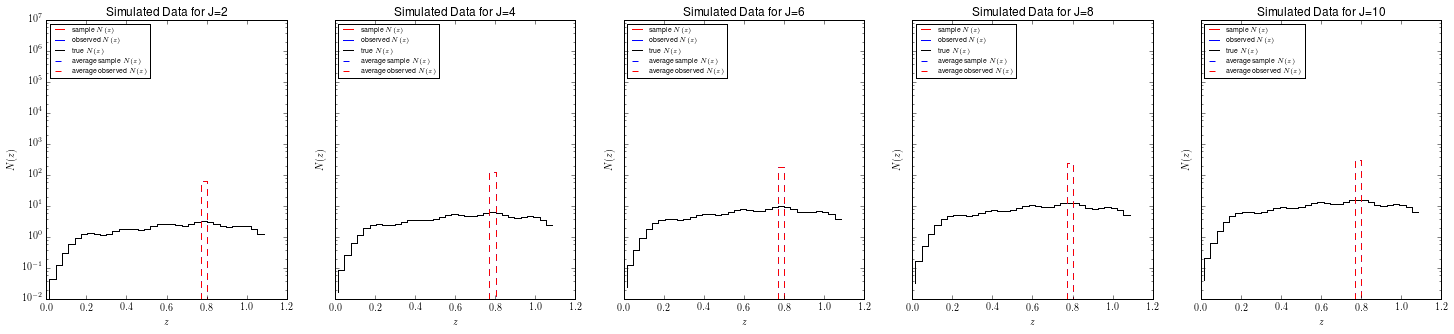

In [330]:
#compare true N(z) to true and observed samples
#randos = [random.choice(range(0,seed_ngals[s])) for s in range(0,nsurvs)]

f,sps = plt.subplots(1, nsurvs, figsize=(5*nsurvs,5),sharey='row')
#for i in range(0,seed_ngals):
for s in range(0,nsurvs):#only one seed this time, don't bother with loop
    sps[s].set_title('Simulated Data for J='+str(seed_ngals[s]))
    sps[s].set_ylabel(r'$N(z)$')
    sps[s].set_xlabel(r'$z$')
    sps[s].semilogy()
    sps[s].set_ylim(1e-2,10**(3+s))
    sps[s].step(binmids,full_trueNz[s],color='r',label=r'sample $N(z)$')
    sps[s].step(binmids,full_trueNz[s],color='b',label=r'observed $N(z)$')
    sps[s].step(binmids,full_trueNz[s],color='k',label=r'true $N(z)$')
    sps[s].step(binmids,avgsamp[s],color='b',label=r'average sample $N(z)$',linestyle='--')
    sps[s].fill_between(binmids,minsamp[s],maxsamp[s],color='b',alpha=0.5,label=r'true sample $N(z)$ RMS errors')
    sps[s].step(binmids,avgobs[s],color='r',label=r'average observed $N(z)$',linestyle='--')
    sps[s].fill_between(binmids,minobs[s],maxobs[s],color='r',alpha=0.5,label=r'observed $N(z)$ RMS errors')
    for n in range(0,nsamps):
        sps[s].step(binmids,sampNz[s][n],c='b',linestyle='--')#,label='true N(z) for draw \#'+str(rando))
        sps[s].step(binmids,obsNz[s][n],c='r',linestyle='--')#,label='observed N(z) for draw \#'+str(rando))
    sps[s].legend(loc='upper left',fontsize='x-small')
f.show()
#plt.savefig('exdata.png')
#plt.close()

In [331]:
#read in the data from a catalog
obsZs,obserrs = [],[]
for s in range(0,nsurvs):
    for n in range(0,nsamps):
        catfile = open(str(n+1)+'datacat'+str(seed_ngals[s])+'.p','r')
        catdat = cPickle.load(catfile)
        obsZ,obserr = zip(*catdat)
        obsZs.append(obsZ)
        obserrs.append(obserr)
        catfile.close()

In [332]:
#generate gaussian likelihood per galaxy per sample per survey to simulate imprecision
logpobs,pobs = [],[]
#n = rando#for one draw when this step is slow
for s in range(0,nsurvs):
    logpob,pob = [],[]
    for n in range(0,nsamps):
        lps,ps = [],[]
        for j in range(0,ngals[s][n]):
            func = norm(loc=obsZs[s][n][j],scale=obserrs[s][n][j])
            lo = np.array([max(sys.float_info.epsilon,func.cdf(binends[k])) for k in range(0,new_nbins)])
            hi = np.array([max(sys.float_info.epsilon,func.cdf(binends[k+1])) for k in range(0,new_nbins)])
            spread = (hi-lo)/zdif
            #normalize probabilities to integrate (not sum)) to 1
            summed = sum(spread)
            p = spread/summed/zdif
            logp = [m.log(max(p_i,sys.float_info.epsilon)) for p_i in p]
            lps.append(logp)
            ps.append(p)
        pob.append(ps)
        logpob.append(lps)
    pobs.append(pob)
    logpobs.append(logpob)
pobs = np.array(pobs)
logpobs = np.array(logpobs)

In [333]:
#MVN prior as class
class mvn(object):
    def __init__(self,mean,cov):
        self.dims = len(mean)
        self.mean = mean
        self.cov = cov
        assert np.all(sp.linalg.eigh(self.cov)[0] >= 0.)
        self.icov = np.linalg.pinv(self.cov,rcond = sys.float_info.epsilon)
        #assert np.all(sp.linalg.eigh(self.icov)[0] >= 0.)
        (self.logdetsign,self.logdet) =  np.linalg.slogdet(self.cov)
        #self.logdet = np.log(-1.*np.linalg.det(self.cov))
        #assert self.logdetsign >= 0.
    def logpdf(self,x):
        delta = x-self.mean
        c = np.dot(delta, np.dot(self.icov, delta))
        prob = -0.5*c
        return prob
    def sample_psamp(self,W):
        #outsamp = [sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov) for n in range(0,N)]
        outsamp = [thing for thing in np.array(np.random.multivariate_normal(self.mean,self.cov,W))]
        #sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return outsamp#,sampprobs
    def sample_gball(self,W):
        #rando = sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov)
        #sigma = 100.#[np.median(self.cov[i]) for i in range(0,dims)]
        outsamp = [self.mean+np.random.randn(self.dims) for w in range(0,W)]#[rando+np.random.randn(dims) for n in range(0,N)]
        #sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return outsamp#,sampprobs
    def sample_sampball(self,W):
        #rando = sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov)
        rando = np.random.multivariate_normal(self.mean,self.cov)
        #rando = self.sample_dumb(1)[0]
        #sigma = 100.#[np.median(self.cov[i]) for i in range(0,dims)]
        outsamp = [rando+np.random.randn(self.dims) for w in range(0,W)]#[rando+np.random.randn(dims) for n in range(0,N)]
        #sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return outsamp,rando#,sampprobs,rando

In [334]:
#permit varying number of parameters for testing
ndim = new_nbins
ndims = [ndim]#5*np.arange(0,7)+5
nlens = len(ndims)
lenno = 0#set parameter dimensions for now
#survno = 0#one survey size for now

#generate prior distribution for each survey size
logmus = [full_logflatNz[s][:ndims[lenno]] for s in range(0,nsurvs)]
#logmus = [full_logflatPz[s][:ndims[lenno]] for s in range(0,nsurvs)]
q=1.#0.5
e=0.1/zdif**2
tiny=q*1e-6
#covmat = [[q*m.exp(-0.5*e*(i-j)**2.) for j in range(0,ndim)] for i in range(0,ndim)]
#covmat = np.array([[q*m.exp(-0.5*e*(i-j)**2.) for j in range(0,ndim)] for i in range(0,ndim)])+tiny*np.identity(ndim)
#covmats = [np.array([[q*m.exp(-0.5*e*(zmids[a]-zmids[b])**2.) for a in range(0,ndim)] for b in range(0,ndim)])+tiny*np.identity(ndim) for ndim in ndims]
covmats = [np.identity(n) for n in ndims]
#priordist = sp.stats.multivariate_normal(mean=logmu,cov=covmat)
#priordist = mvn(logmu,covmat)
priordists = [mvn(logmus[s],covmats[lenno]) for s in range(0,nsurvs)]

In [303]:
#permit varying number of parameters for testing
ndim = new_nbins
ndims = [ndim]#5*np.arange(0,7)+5
nlens = len(ndims)
lenno = 0#set parameter dimensions for now
#survno = 0#one survey size for now

#generate prior distribution for each survey size
logmus = [full_logflatNz[s][:ndims[lenno]] for s in range(0,nsurvs)]
#logmus = [full_logflatPz[s][:ndims[lenno]] for s in range(0,nsurvs)]
q=1.#0.5
e=0.1/zdif**2
tiny=q*1e-6
#covmat = [[q*m.exp(-0.5*e*(i-j)**2.) for j in range(0,ndim)] for i in range(0,ndim)]
#covmat = np.array([[q*m.exp(-0.5*e*(i-j)**2.) for j in range(0,ndim)] for i in range(0,ndim)])+tiny*np.identity(ndim)
covmats = [np.array([[q*m.exp(-0.5*e*(zmids[a]-zmids[b])**2.) for a in range(0,ndim)] for b in range(0,ndim)])+tiny*np.identity(ndim) for ndim in ndims]
#covmats = [np.identity(n) for n in ndims]
#priordist = sp.stats.multivariate_normal(mean=logmu,cov=covmat)
#priordist = mvn(logmu,covmat)
priordists = [mvn(logmus[s],covmats[lenno]) for s in range(0,nsurvs)]

In [335]:
#generate initial values for walkers
nwalkers = 2*new_nbins
#iguess_dumb = priordist.sample_dumb(nwalkers)#[0]
#iguess_legit = priordist.sample_legit(nwalkers)#[0]
#iguess_test,rando_test = priordist.sample_test(nwalkers)#[0]
iguesses_psamp = [priordists[s].sample_psamp(nwalkers) for s in range(0,nsurvs)]#[0]
iguesses_gball = [priordists[s].sample_gball(nwalkers) for s in range(0,nsurvs)]#[0]
sampballguesses = [priordists[s].sample_sampball(nwalkers) for s in range(0,nsurvs)]#[0]
iguesses_sampball,randos_sampball = [sampballguess[0] for sampballguess in sampballguesses],[sampballguess[1] for sampballguess in sampballguesses]
iguesses = [[iguesses_psamp[s],iguesses_gball[s],iguesses_sampball[s]] for s in range(0,nsurvs)]
means = [[logmus[s][0:ndims[lenno]],logmus[s][0:ndims[lenno]],randos_sampball[s][0:ndims[lenno]]] for s in range(0,nsurvs)]
setups = ['Prior Samples','Gaussian Ball Around Mean','Gaussian Ball Around Prior Sample']
setdirs = ['ps/','gm/','gs/']
ntests = len(setups)

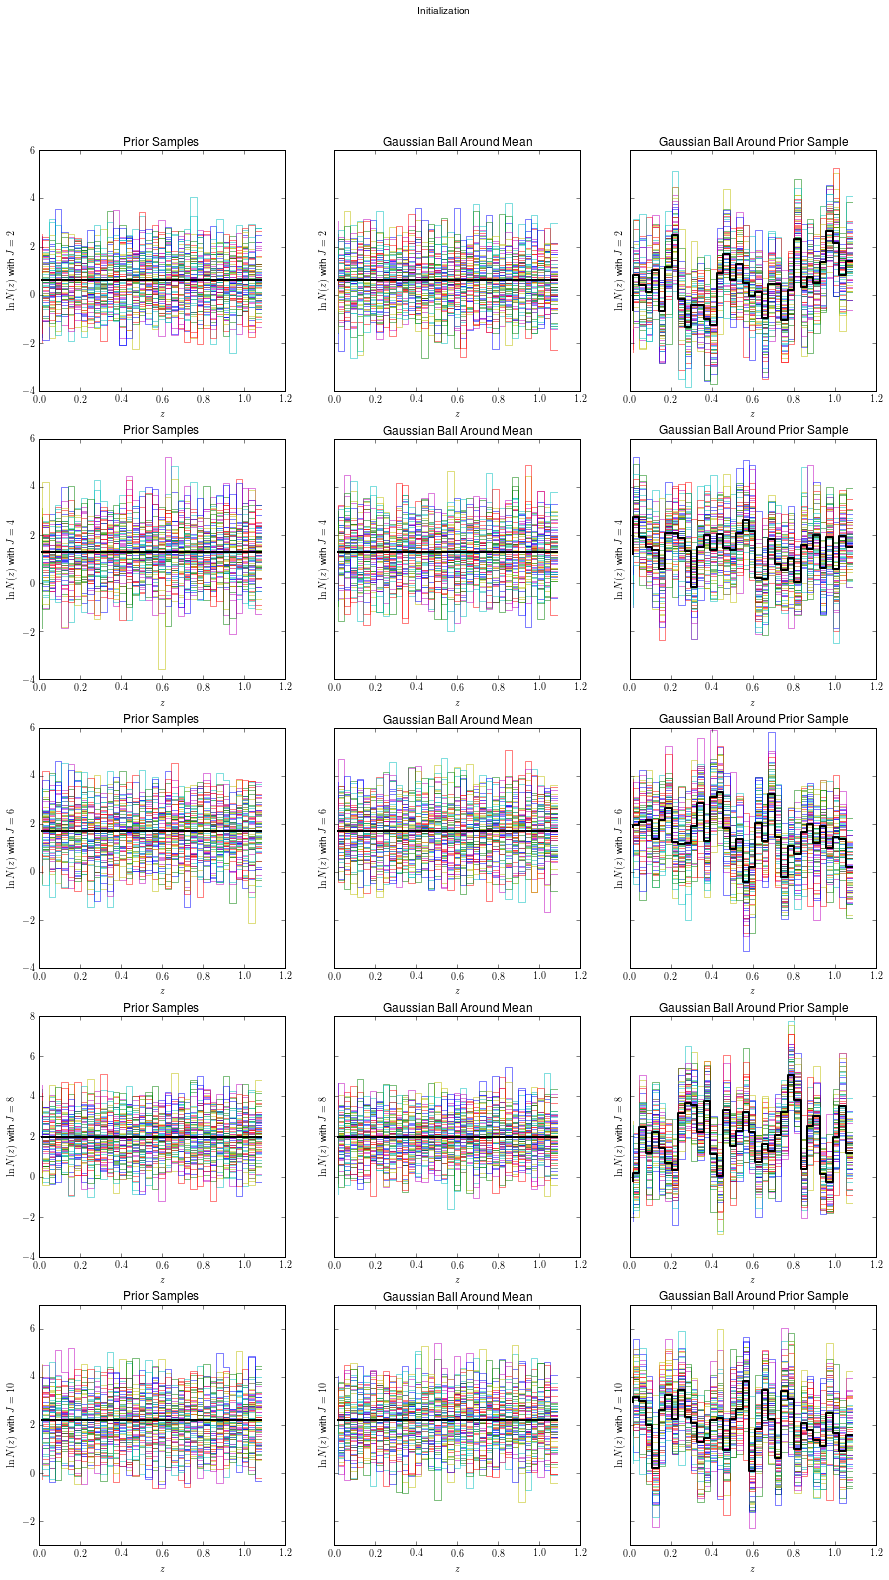

In [336]:
#plt.figure(figsize=(5*ntests,5*nsurvs))

f, sps = plt.subplots(nsurvs, ntests, figsize=(5*ntests,5*nsurvs),sharey='row')
f.suptitle('Initialization')
for s in range(0,nsurvs):
    for t in range(0,ntests):
        sps[s][t].set_ylabel(r'$\ln N(z)$ with $J='+str(seed_ngals[s])+'$')
        sps[s][t].set_xlabel(r'$z$')
        sps[s][t].set_title(setups[t])
        for iguess in iguesses[s][t]:
            sps[s][t].step(zmids[0:ndims[lenno]],iguess,alpha=0.5)
        sps[s][t].step(zmids[0:ndims[lenno]],means[s][t],color='k',linewidth=2)
#f.savefig(str(seed_ngals[s])'initialization-compare.png',dpi=100)
f.show()

In [337]:
#posterior distribution we want to sample as class
class post(object):
    def __init__(self,idist,xvals,yprobs):#data are logged posteriors (nsamps*nbins), idist is mvn object
        self.prior = idist
        self.priormean = idist.mean
#        self.xgrid = xvals
#        self.ndims = len(xvals)-1
#        self.dims = range(0,self.ndims)
        self.postprobs = yprobs
        self.ndats = len(yprobs)
#        self.lndats = np.log(self.ndats)
        self.dats = range(0,self.ndats)
#        self.difs = self.xgrid[1:]-self.xgrid[:-1]#np.array([self.xgrid[k+1]-self.xgrid[k] for k in self.dims])
#        self.logdifs = np.log(self.difs)
#        self.constterm = self.logdifs-self.priormean-self.ndats
    def priorprob(self,theta):#this is proportional to log probability
        return self.prior.logpdf(theta)
    def lnprob(self,theta):#should be able to speed this up some more with matrix magic
        sumterm = self.priorprob(theta)
        #constterms = theta+self.constterm
        for j in self.dats:
            #logterm = sp.misc.logsumexp(self.postprobs[j]+constterms)
            logterm = np.log(np.sum(np.exp(self.postprobs[j]+theta)))#constterms)))
            #intterm = 0.
            #for k in self.dims:
#            likterm = np.exp(self.postprobs[j]+constterms)
            #assert likterm.all() < sys.float_info.max
#            intterm = sum(likterm)
#            logterm = np.log(intterm)
                #likterm = np.exp(theta[k]+self.posts[j][k]-self.priormean[k]+self.logdifs[k])
                #assert likterm >= 0.
                #intterm += likterm
            #logterm = np.log(intterm)
            sumterm += logterm
            #assert (logterm <= 0.), ('theta='+str(theta)+', j='+str(j))
        return sumterm

In [338]:
#set posterior distributions we want to sample
posts = [[post(priordists[s],binends,logpobs[s][n]) for n in range(0,nsamps)] for s in range(0,nsurvs)]
#create the samplers
samplers = [[emcee.EnsembleSampler(nwalkers,ndims[lenno],posts[s][n].lnprob,a=seed_ngals[s]) for n in range(0,nsamps)] for s in range(0,nsurvs)]

In [340]:
#set up directory structure and number of iterations
miniters = int(1e3)
maxiters = int(5e3)#int(1e4)
topdir = 'posttest'+str(maxiters)
topdirs = [[topdir+'/'+str(ngals[s][n])+'/'+str(n) for n in range(0,nsamps)] for s in range(0,nsurvs)]
outdirs = ['times','fracs','probs','chains']
nruns = maxiters/miniters
plot_x = [r*miniters for r in range(1,nruns+1)]
filenames = [str(x)+'.p' for x in plot_x]
plot_x_all = np.arange(0,maxiters)#[np.arange(0.,t) for t in outiters]

In [341]:
#define output directory structure
outpaths = [[[[topdirs[s][n]+'/'+setdirs[t]+outdirs[i] for i in range(0,4)] for t in range(0,ntests)] for n in range(0,nsamps)] for s in range(0,nsurvs)]

In [187]:
#sample miniters of one draw of one survey
def sampling(s,n,ivals):
    samplers[s][n].reset()
    pos, prob, state = samplers[s][n].run_mcmc(ivals, miniters)
    ivals = [walk[-1] for walk in samplers[s][n].chain]
    times = samplers[s][n].get_autocorr_time()#ndims
    fracs = samplers[s][n].acceptance_fraction#nwalkers
    probs = np.swapaxes(samplers[s][n].lnprobability,0,1)#niters*nwalkers
    chains = np.swapaxes(samplers[s][n].chain,0,1)#niters*nwalkers*ndims
    #print(setups[n]+' '+str(ndims[k])+' complete')
    return ivals,[times,fracs,probs,chains]

In [188]:
#sample maxiters of one draw of one survey
def samplings(s,n,t):
    ivals = iguesses[s][t]
    for r in range(0,nruns):
        ivals,outputs = sampling(s,n,ivals)
        for i in range(0,4):
            outname = os.path.join(outpaths[s][n][t][i],filenames[r])
            outfile = open(outname,'w')
            hkl.dump(outputs[i],outfile,mode='w')
            outfile.close()

In [342]:
#profile the sampler on all draws of all surveys
for s in range(0,nsurvs):
    pr = cProfile.Profile()
    pr.enable()
    for n in range(0,nsamps):
        for t in range(0,ntests):
            for outpath in outpaths[s][n][t]:
                if not os.path.exists(outpath):
                    os.makedirs(outpath)
            samplings(s,n,t)
        print('survey '+str(seed_ngals[s])+' sample '+str(n+1)+' done')
    pr.disable()
    sout = StringIO.StringIO()
    sortby = 'tottime'
    ps = pstats.Stats(pr, stream=sout).sort_stats(sortby)
    ps.print_stats()
    print sout.getvalue()

dumping <type 'numpy.ndarray'> to file <HDF5 file "1000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "1000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "1000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "1000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "2000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "2000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "2000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "2000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "3000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "3000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "3000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "3000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "4000.p" (mode r+)>
dumping <type 'numpy.ndarray'> to file <HDF5 file "4000.p" (mode r+)>
dumping <type 'numpy

In [356]:
#plot what some of the samples look like
def plotsamps():
    howmany = 1e2
    a = 1./nsamps/nwalkers
    x_ranges = howmany*np.arange(0,miniters/howmany)#[miniters*((r+1)*np.arange(0,10))/10 for r in range(0,nruns)]
    f,sps = plt.subplots(nsamps, nsurvs, figsize = (5*nsurvs,5*nsamps),sharey='row')
    for s in range(0,nsurvs):
        for n in range(0,nsamps):
            if nsamps > 1:
                thing = sps[s][n]
            else:
                thing = sps[s]
            thing.hlines(logsampNz[s][n],binlos,binhis,color='k',alpha=0.5,label=r'sample $\ln N(z)$',linewidth=2)
            for t in range(0,ntests):
                thing.hlines(full_logflatNz[s],binlos,binhis,color=colors[t],label=setups[t])
                for r in range(0,nruns):
                    #a = (1.+r)/float(miniters)/nsamps
                    yfile = open(os.path.join(outpaths[s][n][t][3],filenames[r]),'r')
                    plot_y = hkl.load(yfile)
                    yfile.close()
                    for x in x_ranges:
                        for w in range(0,nwalkers):
                            thing.hlines(plot_y[x][w],binlos,binhis,color=colors[t],alpha=a)
            thing.hlines(full_logflatNz[s],binlos,binhis,color='k',label=r'flat $\ln N(z)$',linewidth=2)
            thing.hlines(logobsNz[s][n],binlos,binhis,label=r'observed $\ln N(z)$',color='y',linewidth=5)
            thing.legend(fontsize='small',loc='upper left')                 
            thing.set_ylim(-5,seed_ngals[s])
            thing.set_xlabel(r'$z$')
            thing.set_ylabel(r'$\ln N(z)$')
            thing.set_title(r' Sampled $N(z)$ for $J='+str(seed_ngals[s])+r'$')                    
    f.savefig(os.path.join(topdir,'data_results'+str(maxiters)+'i.png'),dpi=100)
    f.show()

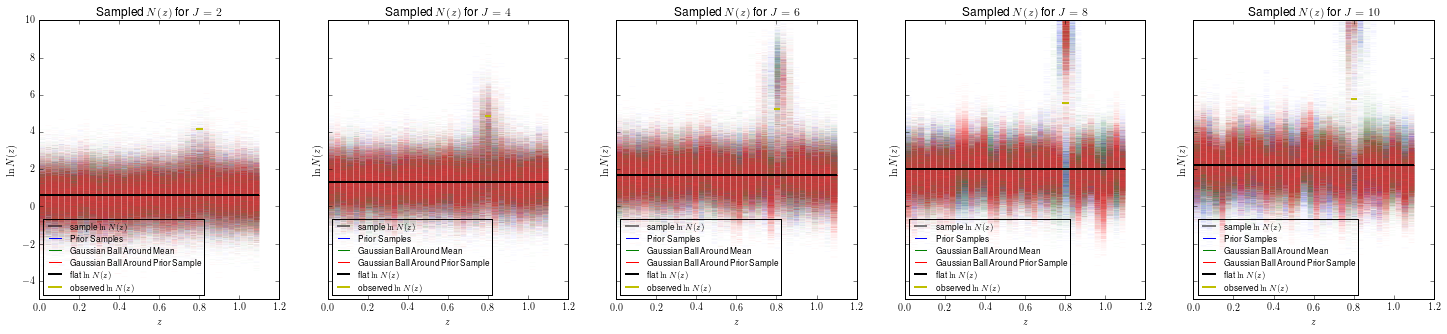

In [357]:
plotsamps()
#note feedback/amplification bug
#had the same feedback loop bug in my MH sampler

In [358]:
def plotprobs():
    a = 1./nwalkers/nsamps
    plot_x_ranges = [plot_x_all[r*miniters:(r+1)*miniters] for r in range(0,nruns)]
    f,sps = plt.subplots(1, nsurvs, figsize = (5*nsurvs,5))
    plt.figure(figsize=(5*nsurvs,5))#one plot per survey
    for s in range(0,nsurvs):
        for t in range(0,ntests):
            sps[s].plot(plot_x_all,[0]*maxiters,c=colors[t],label=setups[t])
            for n in range(0,nsamps):
                for r in range(0,nruns):
                    yfile = open(os.path.join(outpaths[s][n][t][2],filenames[r]),'r')
                    #plot_y = cPickle.load(yfile).T
                    plot_y = hkl.load(yfile).T
                    yfile.close()
                    for w in range(0,nwalkers):
                        sps[s].plot(plot_x_ranges[r],plot_y[w],c=colors[t],alpha=a)
        #plt.ylim(-100,0)
        sps[s].set_title(str(seed_ngals[s])+' Galaxies')
        sps[s].set_ylabel('log probability of walker')
        sps[s].set_xlabel('iteration number')
        sps[s].legend(fontsize='x-small',loc='lower right')
    sps[s].savefig(os.path.join(topdir,'data_pwalker'+str(maxiters)+'i.png'),dpi=100)
    sps[s].show()
    #plt.close()

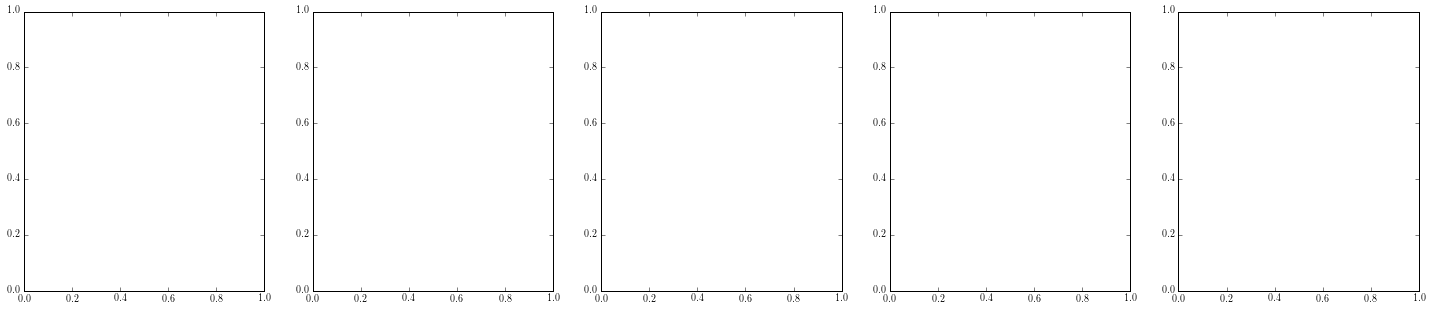

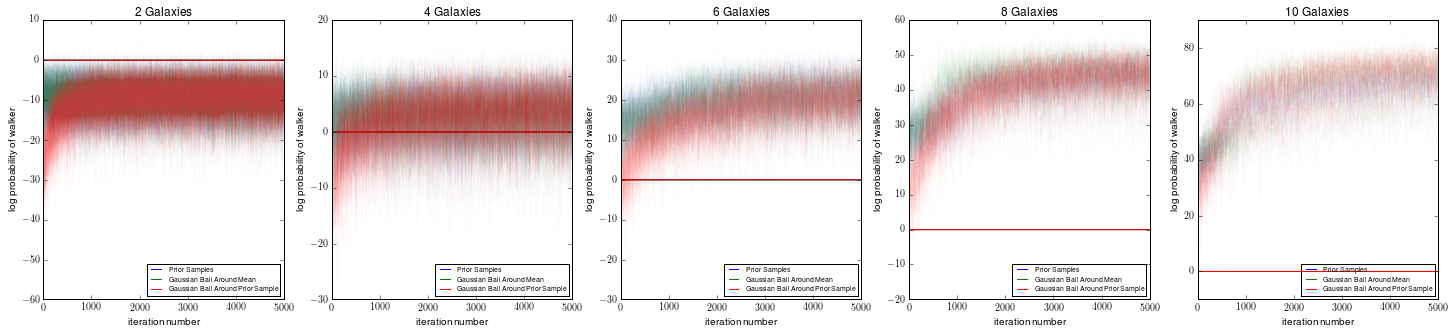

In [359]:
plotprobs()
#log probabilities should not exceed 0!

In [55]:
#plot autocorrelation times as function of iteration number
def plottimes():
    plt.figure(figsize=(5*nsurvs,5))#one plot per dimension of parameters
    a = 1./ndims[lenno]/nsamps
    for s in range(0,nsurvs):
        plt.subplot(1,nsurvs,s+1)
        plt.title('Autocorrelation Times for '+str(nsamps)+' runs of '+str(seed_ngals[s])+' galaxies')
        plt.ylim(0,100)
        plt.xlim(0,maxiters)
        plt.ylabel('autocorrelation time')
        plt.xlabel('number of iterations')
        for t in range(0,ntests):
            plt.scatter([0],[-1],c=colors[t],label=setups[t],linewidths=0.1,s=ndim)
            for n in range(0,nsamps):
                for r in range(0,nruns):
                    yfile = open(os.path.join(outpaths[s][n][t][0],filenames[r]),'r')
                    #plot_y = cPickle.load(yfile).T
                    plot_y = hkl.load(yfile).T
                    #for i in range(0,ndims[k]):
                    plt.scatter([plot_x[r]]*ndims[lenno],plot_y,c=colors[t],alpha=a,linewidths=0.1,s=ndim)
                    yfile.close()
        plt.legend(fontsize = 'small',loc='lower left')
    #plt.savefig(os.path.join(topdir,'acorr-compare-survs.png'),dpi=100)
    plt.show()
    plt.close()

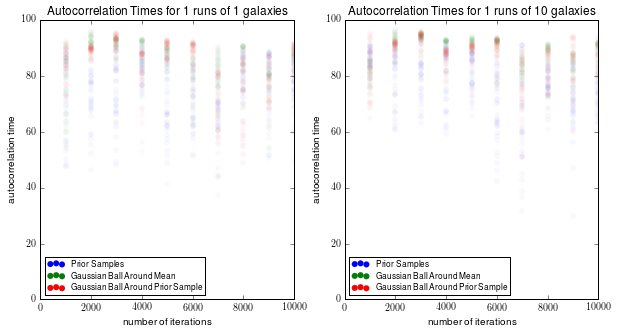

In [56]:
plottimes()

In [57]:
#plot acceptance fractions as function of iteration number
def plotfracs():
    a = 1./ndims[lenno]/nsamps
    plt.figure(figsize=(5*nsurvs,5))#one plot per dimension of parameters
    for s in range(0,nsurvs):
        plt.subplot(1,nsurvs,s+1)
        plt.title('Acceptance Fractions for '+str(nsamps)+' runs of '+str(seed_ngals[s])+' galaxies')
        plt.ylim(0,1)
        plt.xlim(0,maxiters)
        plt.ylabel('acceptance fraction')
        plt.xlabel('number of iterations')
        for t in range(0,ntests):
            plt.scatter([0],[-1],c=colors[t],label=setups[t],linewidths=0.1,s=ndim)
            for n in range(0,nsamps):
                for r in range(0,nruns):
                    yfile = open(os.path.join(outpaths[s][n][t][1],filenames[r]),'r') 
                    plot_y = hkl.load(yfile).T
                    yfile.close()
                    #for i in range(0,nwalkers):
                    plt.scatter([plot_x[r]]*nwalkers,plot_y,c=colors[t],alpha=a,linewidths=0.1,s=ndim)
        plt.legend(fontsize = 'small')
    #plt.savefig(os.path.join(topdir,'fracs-compare-survs.png'),dpi=100)
    plt.show()
    plt.close()

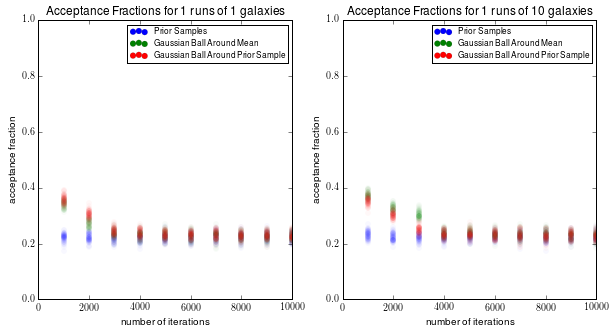

In [58]:
plotfracs()
#np.shape(fracs_all)

In [176]:
def plotchains():
    a = 1./nwalkers
    plot_x_ranges = [plot_x_all[r*miniters:(r+1)*miniters] for r in range(0,nruns)]
    #chosen = 100*np.array([0,100])
    #f = plt.figure(figsize=(5*nlens,5*ndim))#one plot per dimension per number of dimension numbers
    #sps = tuple(range(0,nlens*ndim))
#    f, sps = plt.subplots(ndims[lenno],nsurvs,figsize=(5*nsurvs,5*ndim))
    f, sps = plt.subplots(ndims[lenno], nsurvs, figsize=(5*nsurvs,5*ndim))
    for s in range(0,nsurvs):
        for k in range(0,new_nbins):
            #n = d+s*ndim  
#            sps[k].set_ylim([-5,10])
#            sps[k].set_xlabel('iteration number')
#           sps[k].set_ylabel(r'$\ln N_{'+str(k+1)+'}(z)$')
#            sps[k].set_title(r'$J='+str(seed_ngals[s])+r'$: Parameter '+str(k+1)+' of '+str(ndims[lenno]))
            sps[k][s].set_ylim([-5,20])
            sps[k][s].set_xlabel('iteration number')
            sps[k][s].set_ylabel(r'$\ln N_{'+str(d+1)+'}(z)$')
            sps[k][s].set_title(r'$J='+str(seed_ngals[s])+r'$: Parameter '+str(k+1)+' of '+str(ndims[lenno]))
            for n in range(0,nsamps):
                for t in range(0,ntests):
#                    sps[k].plot(plot_x_all,[logsampNz[s][n][k]]*maxiters,color=colors[t],label=setups[t])
                    sps[k][s].plot(plot_x_all,[full_logtrueNz[k]]*maxiters,color=colors[t],label=setups[t])
#                sps[k].plot(plot_x_all,[logobsNz[s][n][k]]*maxiters,color='y',label='observed value')
#                sps[k].plot(plot_x_all,[logsampNz[s][n][k]]*maxiters,color='k',label='true value')
#            sps[k].legend(fontsize='small',loc='lower left')
            sps[k][s].plot(plot_x_all,[full_logtrueNz[k]]*maxiters,color='k',label='true value')
            sps[k][s].legend(fontsize='small',loc='lower left')
        for n in range(0,nsamps):
            for t in range(0,ntests):
                for r in range(0,nruns):
                    yfile = open(os.path.join(outpaths[s][n][t][3],filenames[r]),'r')
                    #plot_y = cPickle.load(yfile).T
                    plot_y = hkl.load(yfile).T
                    yfile.close()
                    for k in range(0,new_nbins):
                        #n = d*nsurvs+lenno
                        for w in random.sample(range(0,nwalkers),25):#range(0,nwalkers):
#                            sps[k].plot(plot_x_ranges[r],plot_y[k][w],color=colors[t],alpha=a)
                            sps[k][s].plot(plot_x_ranges[r],plot_y[k][w],color=colors[t],alpha=a)
    #plt.savefig(os.path.join(topdir,'compare'+str(maxiters)+'i.png'),dpi=100)
    plt.show()
    plt.close()

In [177]:
plotchains()
#not actually that informative